In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
from scipy import stats
from pathlib import Path

# directory and file paths
data_dir = Path("../data/")
interim_data_dir = data_dir / "interim"
processed_data_dir = data_dir / "processed"

interim_mortgage_file = interim_data_dir / "CountyMortgagesPercent-30-89DaysLate-thru-2020-09.csv"
interim_msa_file = interim_data_dir / "cbsatocountycrosswalk.csv"


In [22]:
mortgage_delinq_df = pd.read_csv(interim_mortgage_file)
mortgage_delinq_df = pd.concat([mortgage_delinq_df.iloc[:,0:4],mortgage_delinq_df.iloc[:,-7:]],axis = 1)
mortgage_delinq_df = mortgage_delinq_df[mortgage_delinq_df['State'].notna()]
mortgage_delinq_df['FIPSCode'] = mortgage_delinq_df['FIPSCode'].str.replace("'",'')
mortgage_delinq_df['FIPSCode'] = mortgage_delinq_df['FIPSCode'].astype(int)
mortgage_delinq_df.head()

,RegionType,State,Name,FIPSCode,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09
1,County,AL,Baldwin County,1003,1.7,1.0,1.1,1.1,1.2,0.8,0.8
2,County,AL,Jefferson County,1073,2.6,1.8,1.5,1.4,1.3,1.4,1.2
3,County,AL,Lee County,1081,2.3,0.9,0.7,0.6,0.6,0.7,0.5
4,County,AL,Madison County,1089,1.8,1.0,1.0,0.7,0.8,1.0,0.9
5,County,AL,Mobile County,1097,3.6,2.4,1.8,2.0,1.9,1.9,1.6


In [24]:
msa_df = pd.read_csv(interim_msa_file)
msa_df = msa_df.iloc[:,0:9]
msa_df.head()

,countyname,state,ssacounty,fipscounty,msa,l,msaname,cbsa,cbsaname
0,AUTAUGA,AL,1000,1001,5240.0,NaN,"MONTGOMERY, AL",33860.0,"Montgomery, AL"
1,BALDWIN,AL,1010,1003,5160.0,NaN,"MOBILE, AL",NaN,NaN
2,BARBOUR,AL,1020,1005,1.0,NaN,ALABAMA,NaN,NaN
3,BIBB,AL,1030,1007,1.0,NaN,ALABAMA,13820.0,"Birmingham-Hoover, AL"
4,BLOUNT,AL,1040,1009,1000.0,NaN,"BIRMINGHAM, AL",13820.0,"Birmingham-Hoover, AL"


In [27]:
mortgage_delinq_df = pd.merge(mortgage_delinq_df, 
                              msa_df, 
                              left_on=['State','FIPSCode'], 
                              right_on = ['state','fipscounty'])

In [26]:
northeast = ["PA", "VT", "ME", "RI", "NY", "CT", "NH", "ME", "NJ"] 
midwest = ["OH", "IN", "IL", "MI", "WI", "MO", "IA", "MN", "KS", "NE", "SD", "ND"]
west = ["WA", "OR", "CA", "NV", "ID", "MT", "WY", "CO", "NM"]
south = ["MD", "DE", "DC", "WV", "VA", "NC", "KY", "TN", "SC", "GA", "FL", "AL", "MS", "AR", "LA", "OK", "TX"]

conditions = [
    (mortgage_delinq_df['State'].isin(northeast)),
    (mortgage_delinq_df['State'].isin(midwest)),
    (mortgage_delinq_df['State'].isin(west)),
    (mortgage_delinq_df['State'].isin(south))
    ]

regions = ['Northeast', 'Midwest', 'West', 'South']

mortgage_delinq_df['Region'] = np.select(conditions, regions)

mortgage_delinq_df.head()

,RegionType,State,Name,FIPSCode,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,...,countyname,state,ssacounty,fipscounty,msa,l,msaname,cbsa,cbsaname,Region
0,County,AL,Baldwin County,1003,1.7,1.0,1.1,1.1,1.2,0.8,...,BALDWIN,AL,1010,1003,5160.0,NaN,"MOBILE, AL",NaN,NaN,South
1,County,AL,Jefferson County,1073,2.6,1.8,1.5,1.4,1.3,1.4,...,JEFFERSON,AL,1360,1073,1000.0,NaN,"BIRMINGHAM, AL",13820.0,"Birmingham-Hoover, AL",South
2,County,AL,Lee County,1081,2.3,0.9,0.7,0.6,0.6,0.7,...,LEE,AL,1400,1081,580.0,NaN,"AUBURN-OPELIKA, AL",12220.0,"Auburn-Opelika, AL",South
3,County,AL,Madison County,1089,1.8,1.0,1.0,0.7,0.8,1.0,...,MADISON,AL,1440,1089,3440.0,NaN,"HUNTSVILLE, AL",26620.0,"Huntsville, AL",South
4,County,AL,Mobile County,1097,3.6,2.4,1.8,2.0,1.9,1.9,...,MOBILE,AL,1480,1097,5160.0,NaN,"MOBILE, AL",33660.0,"Mobile, AL",South


In [46]:
df_melted = mortgage_delinq_df.reset_index().melt(id_vars=['Name', "State", "FIPSCode", "Region"], 
                                                  value_vars=['2020-03',
                                                                                            '2020-04',
                                                                                            '2020-05',
                                                                                            '2020-06',
                                                                                            '2020-07',
                                                                                            '2020-08',
                                                                                            '2020-09'])
df_melted.head()

,Name,State,FIPSCode,Region,variable,value
0,Baldwin County,AL,1003,South,2020-03,1.7
1,Jefferson County,AL,1073,South,2020-03,2.6
2,Lee County,AL,1081,South,2020-03,2.3
3,Madison County,AL,1089,South,2020-03,1.8
4,Mobile County,AL,1097,South,2020-03,3.6


<AxesSubplot:xlabel='variable', ylabel='value'>

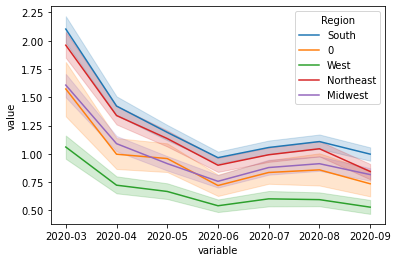

In [47]:
sns.lineplot(data=df_melted, x="variable", y="value", hue = "Region")

In [41]:
df_melted.loc[[0]]

,Name,State,FIPSCode,Region,variable,value
0,United States,NaN,-----,0,2020-03,1.8


In [29]:
df_states = df_melted.iloc[1:, :]
df_states.head()

,Name,State,FIPSCode,Region,variable,value
1,Jefferson County,AL,1073,South,2020-03,2.6
2,Lee County,AL,1081,South,2020-03,2.3
3,Madison County,AL,1089,South,2020-03,1.8
4,Mobile County,AL,1097,South,2020-03,3.6
5,Montgomery County,AL,1101,South,2020-03,3.2


In [51]:
new_df = pd.concat([mortgage_delinq_df.iloc[:,0:11],mortgage_delinq_df['Region']],axis = 1)
print(new_df.head())
new_df_state = new_df.groupby("State").mean()
new_df_state.head()

  RegionType State              Name  FIPSCode  2020-03  2020-04  2020-05  \
0     County    AL    Baldwin County      1003      1.7      1.0      1.1   
1     County    AL  Jefferson County      1073      2.6      1.8      1.5   
2     County    AL        Lee County      1081      2.3      0.9      0.7   
3     County    AL    Madison County      1089      1.8      1.0      1.0   
4     County    AL     Mobile County      1097      3.6      2.4      1.8   

   2020-06  2020-07  2020-08  2020-09 Region  
0      1.1      1.2      0.8      0.8  South  
1      1.4      1.3      1.4      1.2  South  
2      0.6      0.6      0.7      0.5  South  
3      0.7      0.8      1.0      0.9  South  
4      2.0      1.9      1.9      1.6  South  


,FIPSCode,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09
State,,,,,,,,
AK,2020.000000,1.700000,0.900000,1.100000,0.900000,1.000000,0.900000,0.700000
AL,1085.750000,2.487500,1.625000,1.375000,1.125000,1.187500,1.175000,1.075000
AR,5098.500000,1.675000,1.325000,1.100000,0.900000,1.000000,1.050000,0.950000
AZ,4020.000000,1.800000,1.233333,0.933333,0.783333,0.816667,0.883333,0.833333
CA,6061.882353,1.102941,0.755882,0.635294,0.502941,0.555882,0.550000,0.479412


<AxesSubplot:ylabel='State'>

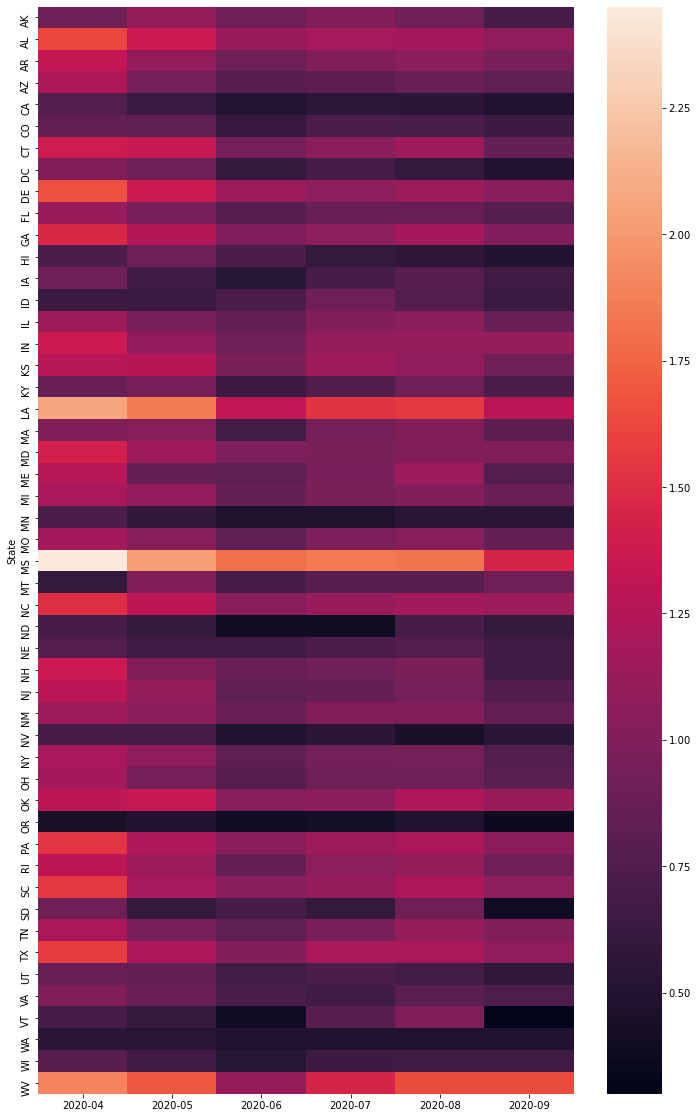

In [52]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12,20))

sns.heatmap(new_df_state.iloc[:,2:9])

In [53]:
new_df_region = new_df.groupby("Region").mean()
new_df_region.head()

,FIPSCode,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09
Region,,,,,,,,
0,22750.653846,1.573077,0.996154,0.957692,0.719231,0.834615,0.857692,0.734615
Midwest,29388.952830,1.607547,1.089623,0.913208,0.756604,0.878302,0.912264,0.816038
Northeast,34807.469136,1.960494,1.338272,1.134568,0.898765,0.991358,1.044444,0.843210
South,29912.613757,2.103175,1.422222,1.189418,0.965608,1.055556,1.107937,0.996825
West,19371.194444,1.059722,0.722222,0.666667,0.540278,0.601389,0.594444,0.527778


<AxesSubplot:ylabel='Region'>

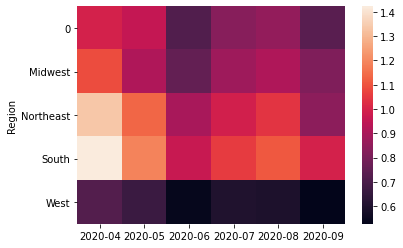

In [56]:
sns.heatmap(new_df_region.iloc[:,2:9])